In [1]:
import lightkurve as lk
import giants as g
import numpy as np

In [2]:
# tic = 181862539 #TCE
tic = 17639611

In [3]:
lcc = g.Giant().from_eleanor(tic)

Using the brightest 727 targets.
Creating light curve for target 17639611 for sectors [12].


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
100%|██████████| 1289/1289 [00:15<00:00, 85.65it/s]


In [4]:
# sneaky nonsense
lc5 = lk.search_lightcurvefile('k2-199')[0].download()

In [5]:
lc = lcc[1]
lc.time_format = 'jd'
lc.quality = np.ones(len(lc.time), dtype='int')
lc.cadenceno = lc5.cadenceno[:len(lc.time)]

In [6]:
lc.remove_outliers().interact_bls('localhost:8888')

In [7]:
period = 1.57141
t0 = .927

In [8]:
lc = lc[100:]

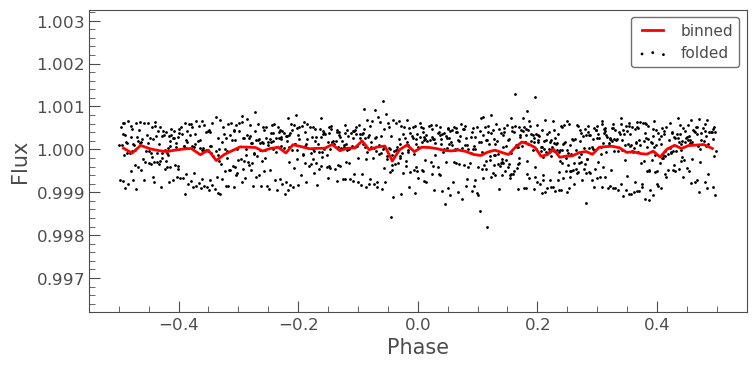

In [9]:
ax = lc.flatten().remove_outliers().fold(period, t0).scatter(c='k', label='folded')
lc.flatten().remove_outliers().fold(period, t0).bin().plot(ax=ax, c='r', label='binned', lw=2)

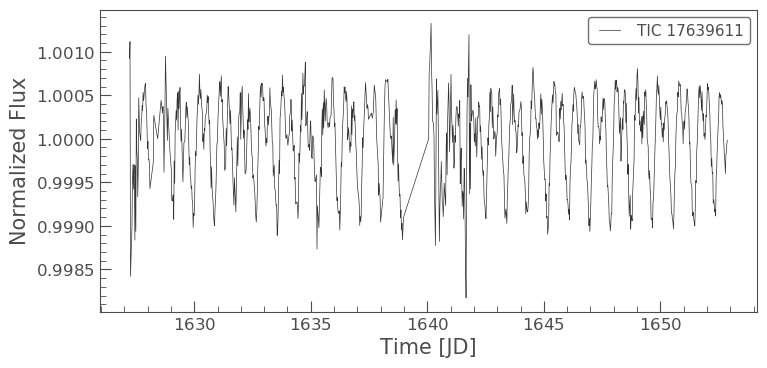

In [10]:
lc.remove_outliers().flatten().plot(label=f'TIC {tic}')

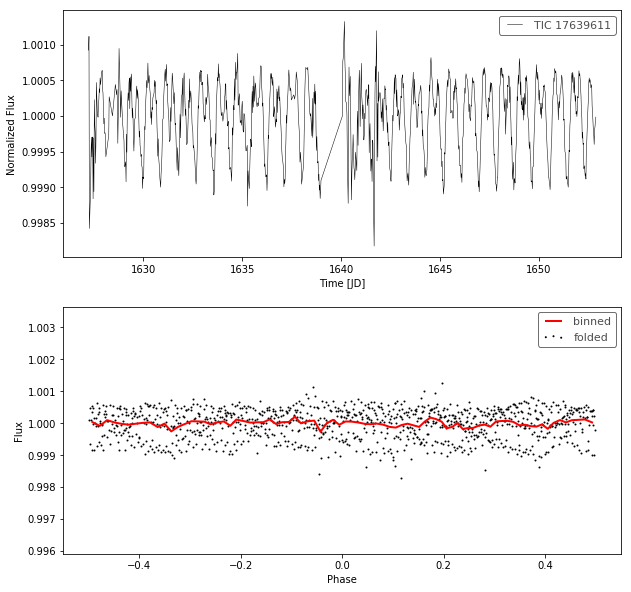

ERROR:bokeh.server.protocol_handler:error handling message Message 'PATCH-DOC' (revision 1) content: {'events': [{'kind': 'ModelChanged', 'model': {'type': 'Slider', 'id': '1002'}, 'attr': 'value', 'new': 0.38}], 'references': []}: IndexError('index 1900 is out of bounds for axis 0 with size 1857',)
ERROR:bokeh.server.protocol_handler:error handling message Message 'PATCH-DOC' (revision 1) content: {'events': [{'kind': 'ModelChanged', 'model': {'type': 'Slider', 'id': '1002'}, 'attr': 'value', 'new': 0.5}], 'references': []}: IndexError('index 1900 is out of bounds for axis 0 with size 1712',)
ERROR:bokeh.server.protocol_handler:error handling message Message 'PATCH-DOC' (revision 1) content: {'events': [{'kind': 'ModelChanged', 'model': {'type': 'Slider', 'id': '1002'}, 'attr': 'value', 'new': 0.4900000000000001}], 'references': []}: IndexError('index 1900 is out of bounds for axis 0 with size 1712',)
ERROR:bokeh.server.protocol_handler:error handling message Message 'PATCH-DOC' (revi

In [11]:
import matplotlib.pyplot as pl
fig, ax = pl.subplots(2, figsize=(10,10))
lc.remove_outliers().flatten(window_length=101).plot(ax=ax[0], label=f'TIC {tic}', c='k')
lc.flatten(window_length=501).remove_outliers().fold(period, t0).scatter(ax=ax[1], c='k', label='folded')
lc.flatten().remove_outliers().fold(period, t0).bin().plot(ax=ax[1], c='r', label='binned', lw=2)

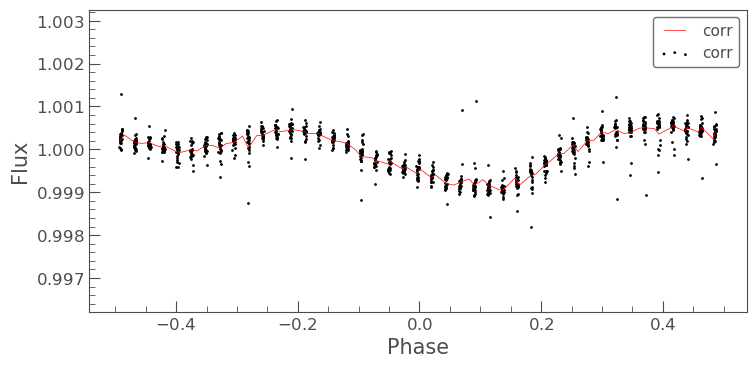

In [18]:
p = 0.896
t = 0.026
ax = lc.flatten().remove_outliers().fold(p, t).scatter(c='k')
lc.flatten().remove_outliers().fold(p, t).bin().plot(ax=ax, c='r')

In [28]:
tpf = lk.search_tesscut(181862539).download(cutout_size=11)

In [31]:
tpf.interact('http://localhost:8888')

In [30]:
tpf.interact_sky()